## Face Recognition using Principal Component Analysis

We will create a basic facial recognition system using a technique called principal component analysis (PCA) by projecting the face images on the feature space (face space) which best represents the variations among distinct faces. The face space is defined as the “Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import time

/home/oknaitik/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [2]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


In [3]:
trainFaces[0][: 20]

array([[25, 25, 23, ..., 19, 22, 22],
       [25, 27, 24, ..., 20, 21, 24],
       [26, 26, 24, ..., 21, 20, 23],
       ...,
       [26, 29, 27, ..., 69, 68, 52],
       [25, 28, 29, ..., 68, 64, 71],
       [31, 29, 28, ..., 55, 59, 65]], dtype=uint8)

In [4]:
np.unique(trainFaces)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [5]:
np.unique(testLabels)

array([ 1,  2,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 18, 19, 21, 22, 23,
       24, 25, 27, 28, 29, 30, 32, 33, 34, 37, 38, 39, 40])

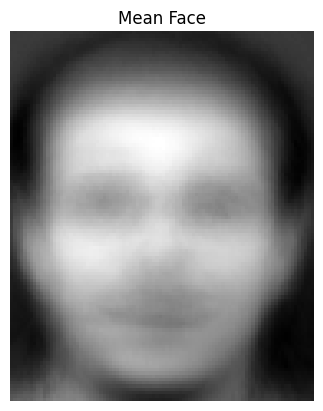

In [6]:
mean_face = np.mean(trainFaces, axis=0)
plt.imshow(mean_face, cmap='gray')
plt.title(f'Mean Face')
plt.axis('off')
plt.show()

#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

#### Explanation:
- For each image, flatten the 2D image array to 1D array.
- Find the covariance matrix with the list of flattened vectors.
- Compute eigenvalues and eigenvectors
- Sort the eigenvalues in descending order
- Return the desired number of eigenfaces

In [7]:
def getEigenVectors(X):
    # your code here
    X_flat = X.reshape((X.shape[0], -1)) # flatten the image matrix 
    # scaler = StandardScaler()
    # X_flat = scaler.fit_transform(X_flat) # normalize data

    cov_matrix = np.cov(X_flat.T) # shape of input: features x samples
    eig_val, eig_vec = np.linalg.eig(cov_matrix)
    
    sorted_indices = np.argsort(eig_val)[::-1] # sort the eigenvalues in descending order
    sorted_eigenvec = eig_vec[:, sorted_indices] # each column forms an eigenvector

    return eig_val[sorted_indices], sorted_eigenvec

In [8]:
def principalComponentAnalysis(eigenVectors, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """
    return eigenVectors[:, :numComponents]

In [9]:
start = time.time()
eigen_values, eigen_vectors = getEigenVectors(trainFaces) # all eigen vectors in decreasing order of importance
end = time.time()
print('Time:', (end - start)//60)

Time: 14.0


#### Scree Plot 

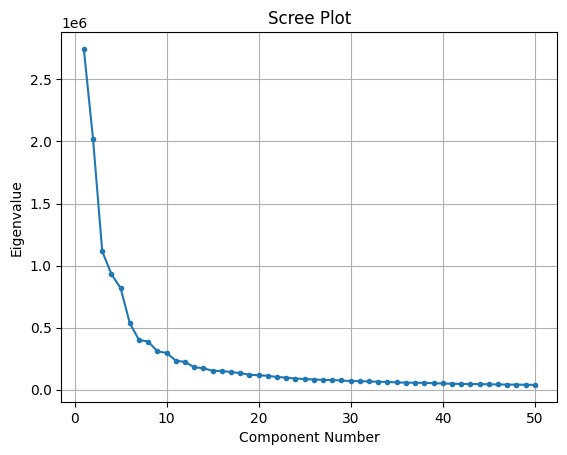

In [10]:
components = range(trainFaces.shape[1] * trainFaces.shape[2]) 
n = 50
plt.plot(np.array(components[: n]) + 1, np.real(eigen_values)[: n], '.-')
plt.title('Scree Plot')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

#### Observation:
The scree plot indicates that the elbow lies at around $K_e=$8. It implies that we could assume ${K_e}$  number of components and capture most of the information. This will be evident later in the Accuracy plot.

In [11]:
pc = 1000
eigenfaces = principalComponentAnalysis(eigen_vectors, pc)

In [12]:
eigenfaces.shape

(10304, 1000)

#### Plot Eigenfaces

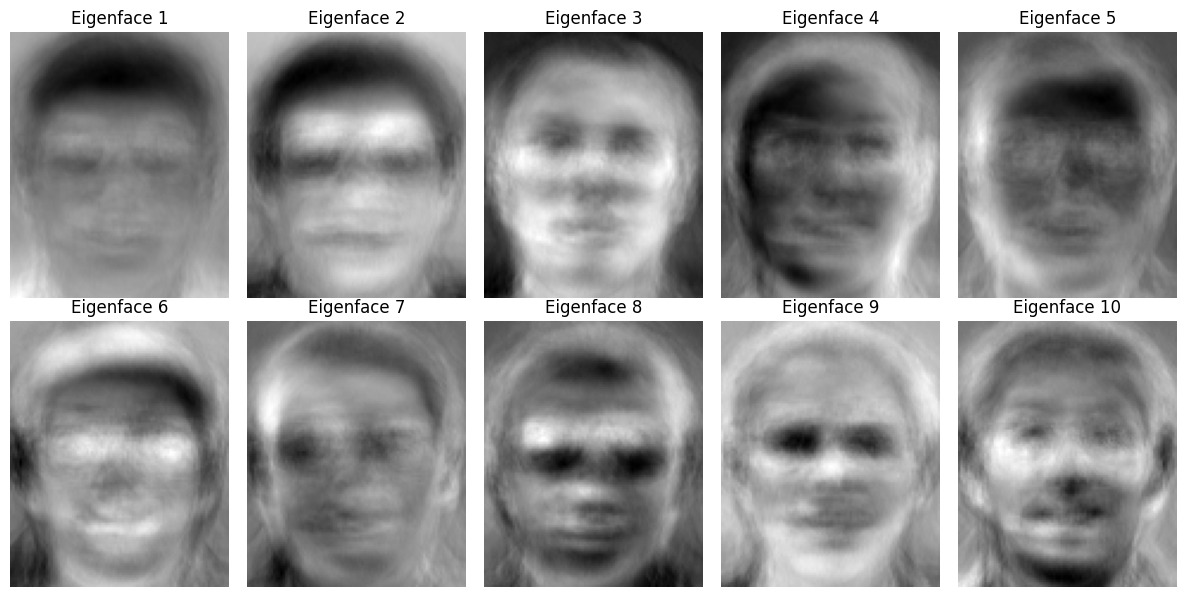

In [13]:
%matplotlib inline

# plot the first 10 eigenfaces
num_eigenfaces_to_plot = 10
plt.figure(figsize=(12, 6))
for i in range(num_eigenfaces_to_plot):
    plt.subplot(2, 5, i + 1)
    # reshape the ith eigenface
    eigenface_reshaped = eigenfaces[:, i].reshape(trainFaces.shape[1], trainFaces.shape[2])
    plt.imshow(np.real(eigenface_reshaped), cmap='gray')
    plt.title(f'Eigenface {i + 1}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

#### Explanation:
- Find the projection of test face on each eigenface
- The projection forms the weight of kth eigenface
- We use linear combination of eigenfaces with the weights computed to get the reconstructed face


In [14]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """
  
    # your code here
    testFace_flat = testFace.reshape((1, -1)) # flatten the test face array
    meanFace_flat = meanFace.reshape((1, -1))
    
    weights =  np.dot(testFace_flat - meanFace_flat, eigenFaces) # project the testface onto the facespace
   
    reconstructedTestFace = np.dot(weights, eigenFaces.T)
    return reconstructedTestFace

#### Plot Reconstructions of Test Faces for PC=200 

In [15]:
def plotReconstructions(num_test, numPrincipalComponents):
    mean_face = np.mean(trainFaces, axis=0) # mean of all training faces
    num_test = 5
    np.random.seed(42)
    test_indices = np.random.randint(testFaces.shape[0], size=num_test)

    plt.figure(figsize=(12, 15))
    for iter in range(num_test):
        i = test_indices[iter]
        plt.subplot(1, num_test, iter + 1)
        plt.imshow(testFaces[i], cmap='gray')
        plt.title(f'Test Face {i + 1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    for pc in numPrincipalComponents:
        eigenfaces = principalComponentAnalysis(eigen_vectors, pc)

        mean_face = np.mean(trainFaces, axis=0)
        plt.figure(figsize=(12, 15))
        for iter in range(num_test):
            i = test_indices[iter]
            test_face_reconst = np.real(imageReconstruction(testFaces[i], eigenfaces, mean_face))
            test_face_reconst_reshaped = test_face_reconst.reshape((testFaces.shape[1], testFaces.shape[2]))  # reshape the reconstructed face
        
            plt.subplot(2, num_test, num_test + iter + 1)
            plt.imshow(test_face_reconst_reshaped, cmap='gray')
            plt.title(f'Reconstructed\nTest Face {i + 1} (PC: {pc})')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

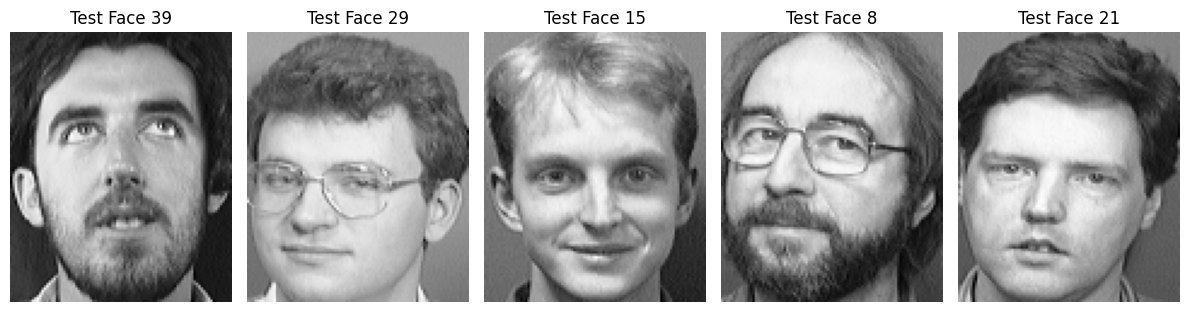

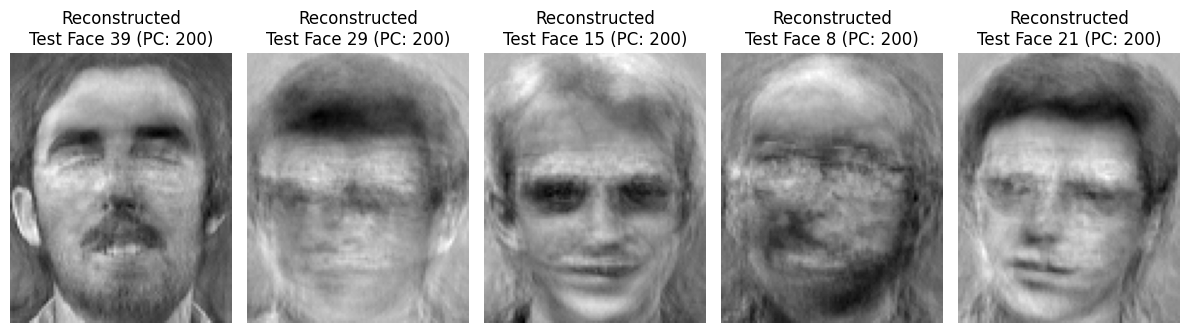

In [16]:
plotReconstructions(5, [200])

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

In [17]:
def displayNfactors(numPrincipalComponents, num_test=5):
    plotReconstructions(num_test, numPrincipalComponents)

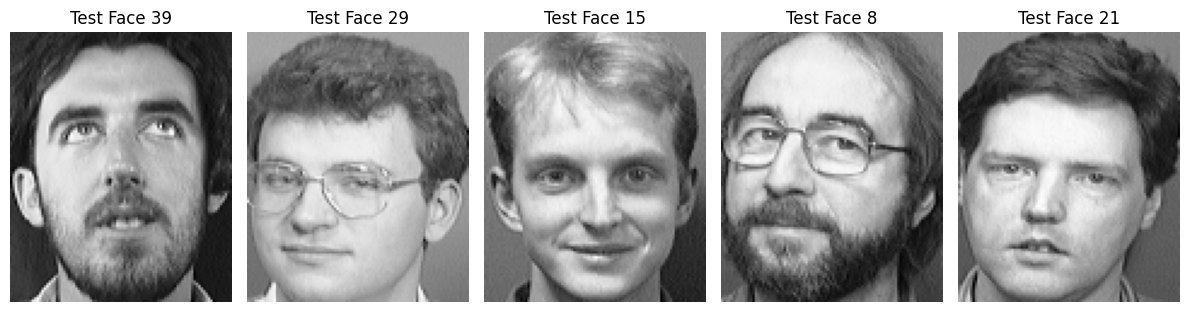

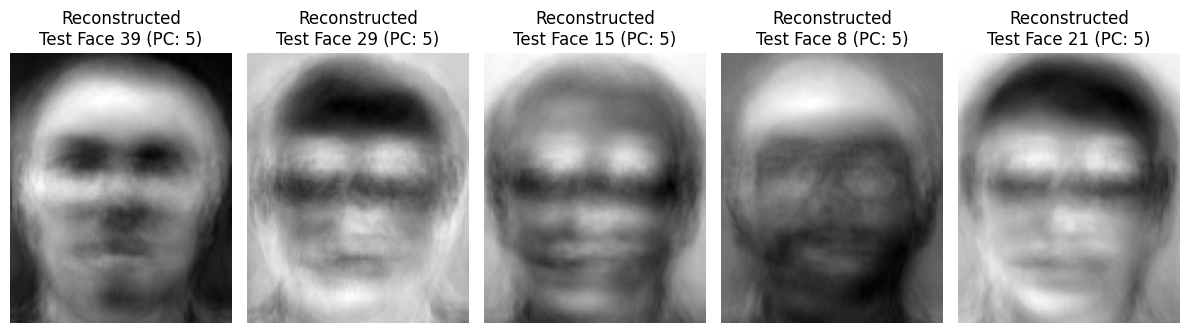

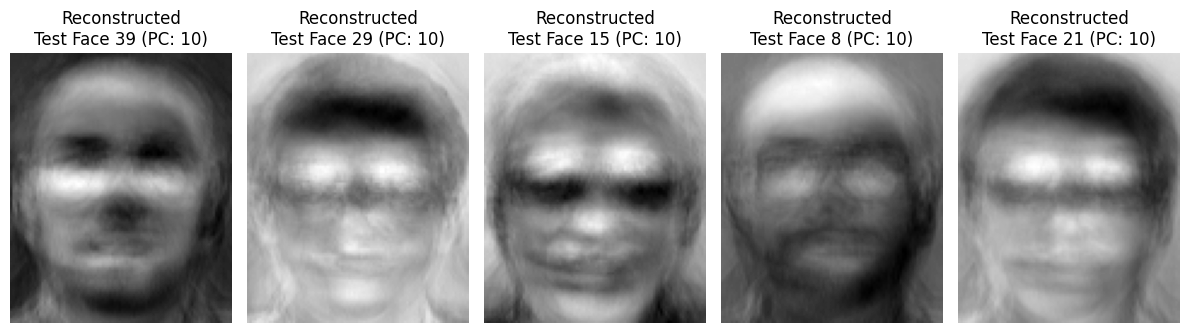

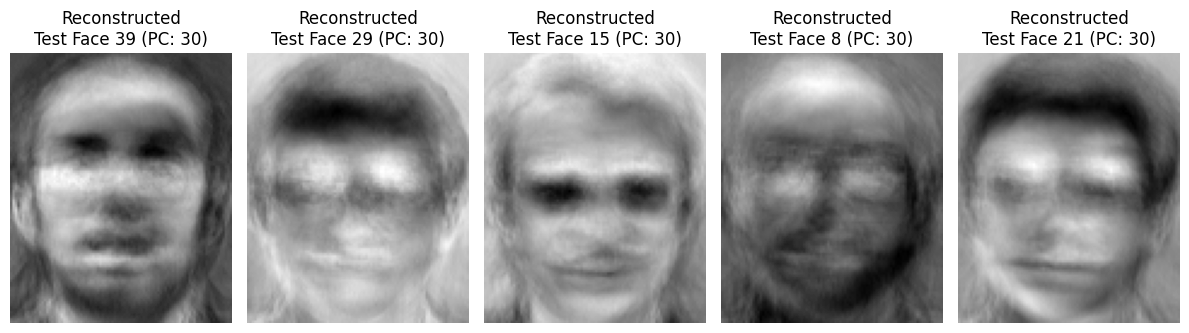

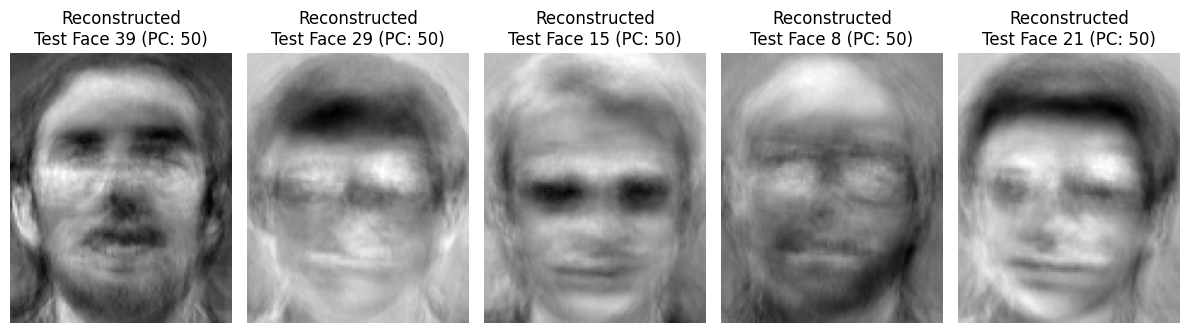

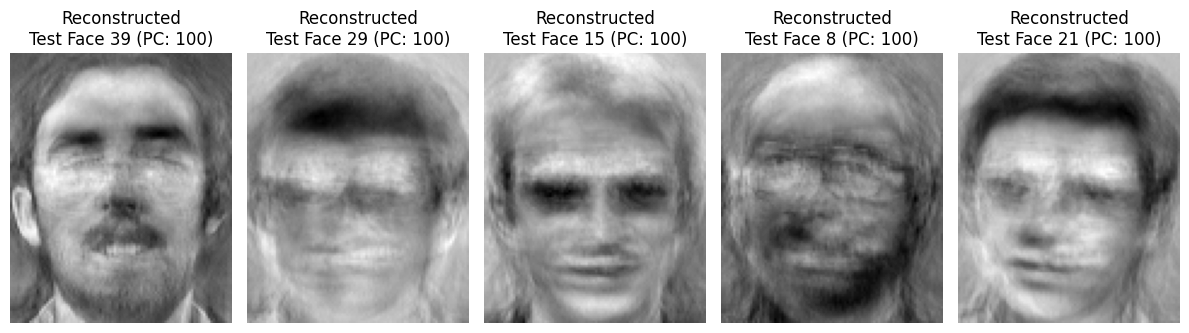

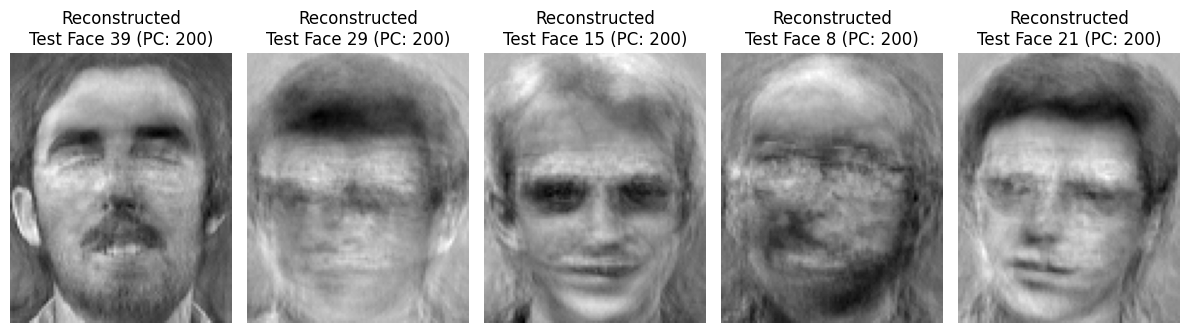

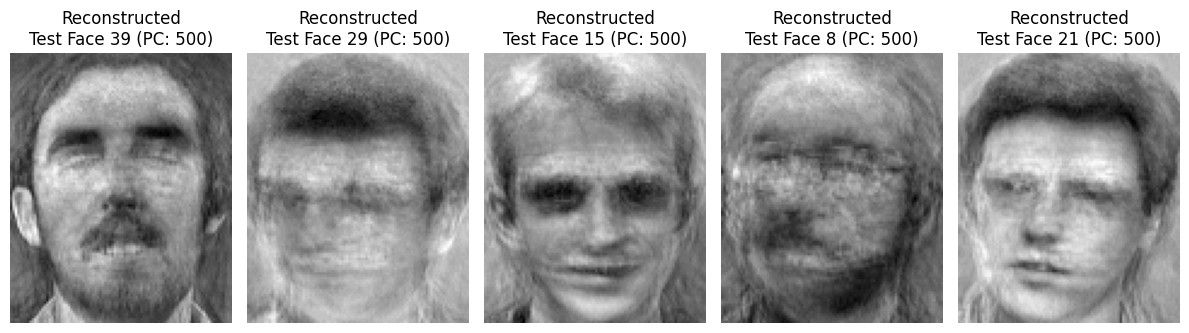

In [18]:
num_principal_comp = [5, 10, 30, 50, 100, 200, 500] 
displayNfactors(num_principal_comp)

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

#### Explanation
- Compute the projection of test face onto facespace
- Find the norm separation of the projection from all the training images (flattened)
- Get the training image closest to the test face projection
- The distance of a test face from its projection onto the facespace measures the "faceness" of test image. If the separation is low, the area appears as dark in the facemap. However, we will not evaluate this.

In [19]:
def getClass(testFace, eigenFaces, meanFace):
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """

    # your code here
    testFace_flat = testFace.reshape((1, -1)) # flatten the test face array
    meanFace_flat = meanFace.reshape((1, -1))
    
    test_face_proj =  np.dot(testFace_flat - meanFace_flat, eigenFaces) # project the testface onto the facespace
                                                                # weights array
    # print(weights.shape)
    # reconstructedTestFace = np.dot(weights, eigenFaces.T) # reconstruct the test face using linear combination
                                                        # already flattened
    trainFaces_flat = trainFaces.reshape((trainFaces.shape[0], -1)) 

    # print(trainFaces_flat.shape, eigenFaces.shape)
    train_face_proj =  np.dot(trainFaces_flat - meanFace_flat, eigenFaces)
    # compute norm distance for each train face
    errors = np.linalg.norm(train_face_proj - test_face_proj, axis=1)/ eigenFaces.shape[1]

    # get the closest train face
    min_error_index = np.argmin(errors)

    min_error = errors[min_error_index]
    best_face = trainFaces[min_error_index]
    predicted_class = trainLabels[min_error_index]

    return min_error, best_face, predicted_class

Iterate through all the images in the test data and test the accuracy by taking different number of components

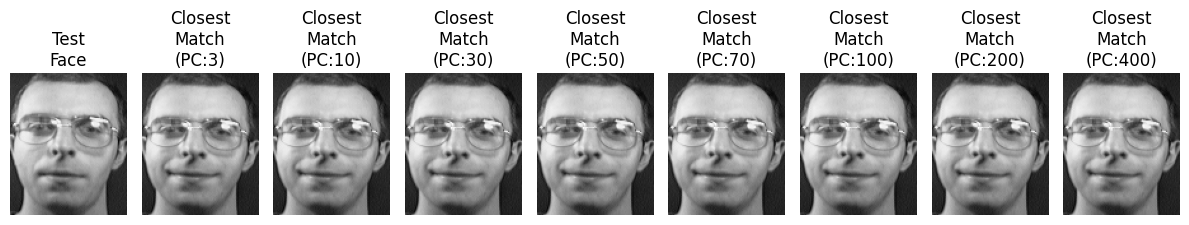

In [20]:
components = [3,10,30,50,70,100,200,400]
mse = []
accuracy = []

mean_face = np.mean(trainFaces, axis=0) # mean of all training faces
plt.figure(figsize=(12, 6))
for iter in range(len(components)):
    # your code here
    eigenfaces = principalComponentAnalysis(eigen_vectors, components[iter])
    total_error = 0
    correct_preds = 0

    index = np.random.randint(testFaces.shape[0])
    
    plt.subplot(1, len(components)+1, 1)
    plt.imshow(testFaces[0], cmap='gray')
    plt.title(f'Test\nFace')
    plt.axis('off')
    
    for i in range(testFaces.shape[0]):
        min_error, closest_match, predicted_class = getClass(testFaces[i], eigenfaces, mean_face)
        total_error += min_error
        if predicted_class == testLabels[i]:
            correct_preds += 1

        if i == 0:
            plt.subplot(1, len(components)+1, iter + 2)
            plt.imshow(closest_match, cmap='gray')
            plt.title(f'Closest\nMatch\n(PC:{components[iter]})')
            plt.axis('off')
    total_error /= testFaces.shape[0]
    mse.append(total_error)
    accuracy.append(correct_preds/ testFaces.shape[0])

plt.tight_layout()
plt.show()

#### Plot Accuracy vs Number of PC

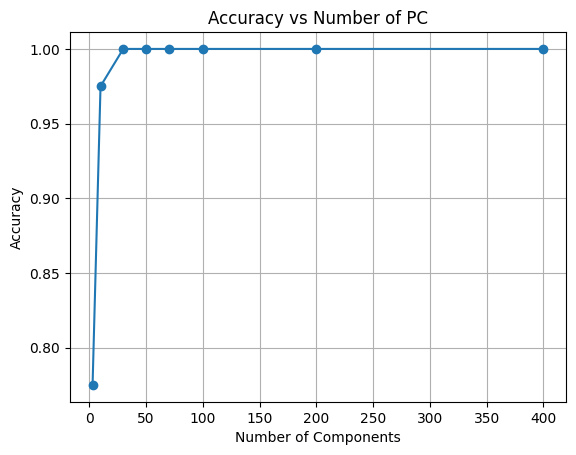

In [21]:
# Plot the accuracies
plt.plot(components, accuracy, 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of PC')
plt.grid(True)
plt.show()

#### Observations:
As number of eigen faces in the facespace increases, the accuracy of face detection should improve as the projections are more feature-rich. However, beyond a certain point, the accuracy plateaus. Recall that the Scree plot indicated that till $K=8$, we would be able to capture most of the variance which is evident above. By $K=10$, we have achieved over 95% accuracy.  

#### Plot Mean Square Error vs Number of PC

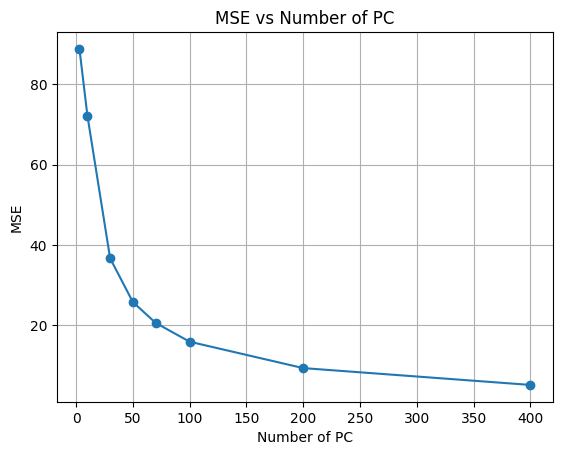

In [22]:
# your code here
plt.plot(components, mse, 'o-')
plt.title('MSE vs Number of PC')
plt.xlabel('Number of PC')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

#### Plot MSE vs Log Number of PC

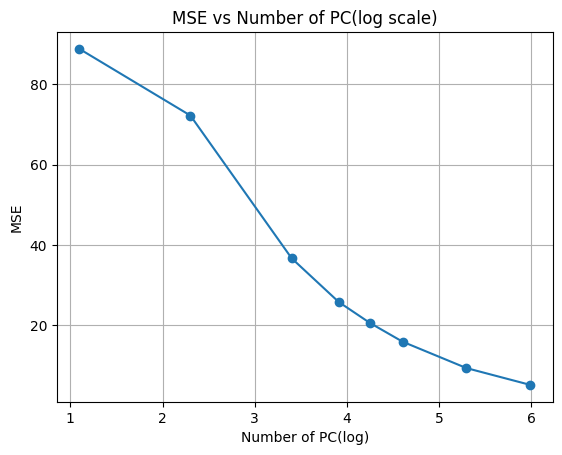

In [23]:
# your code here
plt.plot(np.log(components), mse, 'o-')
plt.title('MSE vs Number of PC(log scale)')
plt.xlabel('Number of PC(log)')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

#### Observations:
As the number of PC increases, the Facespace is more representative of the original space and details in the reconstructed face are enhanced. For this reason, we observe steady decrease in MSE. 